 - Обучить AE собственной архитектуры на MNIST
 - Обучить VAE собственной архитектуры на MNIST
 - *Обучить VAE c переносом стиля на MNIST (на вход декодеру подавать hidden с таргетным значением, чтобы можно было нарисовать заданную цифру в заданном стиле)

In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

1. Обучить AE собственной архитектуры на MNIST

Гиперпараметры:

In [2]:
input_channels = 1      # один канал на входе (1 черно-белая картинка)
hidden_channels = 32    # количество матриц с результатами свертки
device_id = -1
device = 'mps' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 20
batch_size = 64

Архитектура модели:

In [3]:
class ConvEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.do1 = nn.Dropout(0.2)
    
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.do2 = nn.Dropout(0.2)   
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do3 = nn.Dropout(0.2)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do4 = nn.Dropout(0.2)

    self.pool2 = nn.MaxPool2d(2, 2) # 7x7
    self.conv5 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1,   # out_ch = 1 - все фичи утрамбовываются в 1 матрицу 7x7
                           padding=1) # 7x7
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.pool1(self.do2(self.activ(self.conv2(self.do1(self.activ(self.conv1(x)))))))
    x = self.pool2(self.do4(self.activ(self.conv4(self.do3(self.activ(self.conv3(x)))))))
    x = self.conv5(x)

    return x


In [4]:
class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do1 = nn.Dropout(0.2)

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.do2 = nn.Dropout(0.2)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14x14       # обратная пулингу операция
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do3 = nn.Dropout(0.2)
    self.conv4 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 14x14
    self.do4 = nn.Dropout(0.2)

    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv5 = nn.Conv2d(hidden_ch, input_ch, kernel_size=3, stride=1, 
                           padding=1) # 28x28
    self.activ = nn.ReLU()
  def forward(self, x):
    x = self.upsample1(self.do2(self.activ(self.conv2(self.do1(self.activ(self.conv1(x)))))))
    x = self.upsample2(self.do4(self.activ(self.conv4(self.do3(self.activ(self.conv3(x)))))))
    x = self.conv5(x)


    return x


In [5]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_

Загрузчик данных:

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# скачивание обучающего датасета
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

# скачивание тестового датасета
dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

100%|████████████████████████████| 9912422/9912422 [00:03<00:00, 2605113.92it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 612910.82it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 2319921.14it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 2303292.08it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



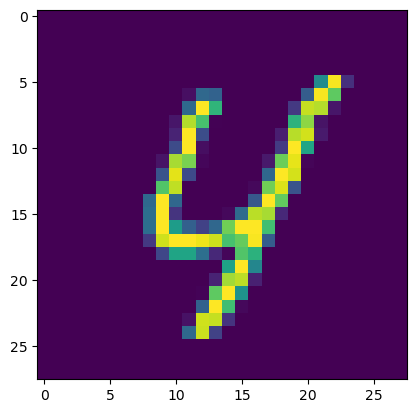

In [7]:
plt.imshow(dataset_test.data[555].detach().numpy())
plt.show()

Инициализация модели, задание оптимизатора и функции потерь:

In [8]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss()

Трейн луп

epoch: 0, step: 0, loss: 0.07095099240541458
epoch: 0, step: 200, loss: 0.0727388858795166
epoch: 0, step: 400, loss: 0.06807264685630798
epoch: 0, step: 600, loss: 0.07606817781925201
epoch: 0, step: 800, loss: 0.07518814504146576


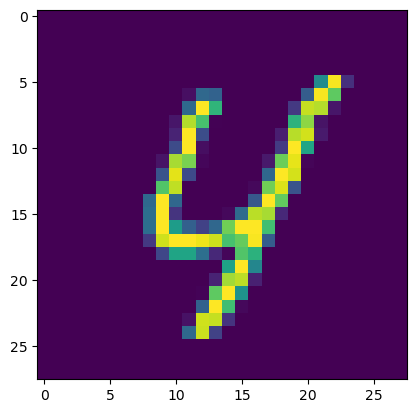

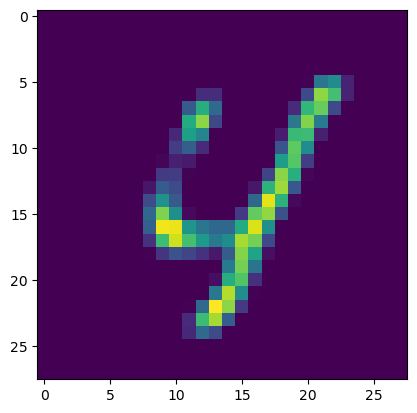

epoch: 1, step: 0, loss: 0.0718611478805542
epoch: 1, step: 200, loss: 0.06907997280359268
epoch: 1, step: 400, loss: 0.06956653296947479
epoch: 1, step: 600, loss: 0.06816116720438004
epoch: 1, step: 800, loss: 0.07143139094114304
epoch: 2, step: 0, loss: 0.07156521081924438
epoch: 2, step: 200, loss: 0.07078635692596436
epoch: 2, step: 400, loss: 0.06731007248163223
epoch: 2, step: 600, loss: 0.07232973724603653
epoch: 2, step: 800, loss: 0.07183395326137543
epoch: 3, step: 0, loss: 0.07145538926124573
epoch: 3, step: 200, loss: 0.07028786092996597
epoch: 3, step: 400, loss: 0.07081346213817596
epoch: 3, step: 600, loss: 0.06526082009077072
epoch: 3, step: 800, loss: 0.0716952383518219
epoch: 4, step: 0, loss: 0.07711537182331085
epoch: 4, step: 200, loss: 0.07132154703140259
epoch: 4, step: 400, loss: 0.0689968690276146
epoch: 4, step: 600, loss: 0.07385618984699249
epoch: 4, step: 800, loss: 0.07499333471059799
epoch: 5, step: 0, loss: 0.072672538459301
epoch: 5, step: 200, loss: 0

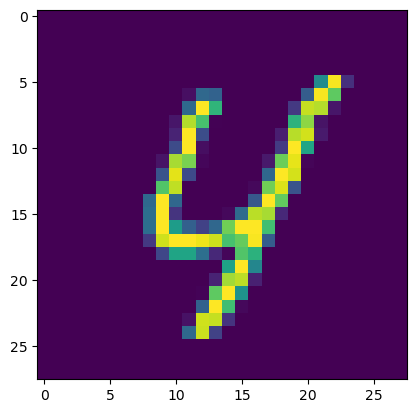

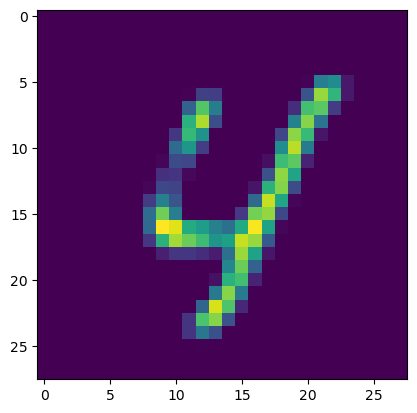

epoch: 6, step: 0, loss: 0.06923235207796097
epoch: 6, step: 200, loss: 0.0689472183585167
epoch: 6, step: 400, loss: 0.07014745473861694
epoch: 6, step: 600, loss: 0.06985439360141754
epoch: 6, step: 800, loss: 0.07242037355899811
epoch: 7, step: 0, loss: 0.06813430786132812
epoch: 7, step: 200, loss: 0.06705698370933533
epoch: 7, step: 400, loss: 0.06870494782924652
epoch: 7, step: 600, loss: 0.07288698107004166
epoch: 7, step: 800, loss: 0.06898067146539688
epoch: 8, step: 0, loss: 0.06817801296710968
epoch: 8, step: 200, loss: 0.06662621349096298
epoch: 8, step: 400, loss: 0.06583791971206665
epoch: 8, step: 600, loss: 0.06977485120296478
epoch: 8, step: 800, loss: 0.07046101987361908
epoch: 9, step: 0, loss: 0.07004731893539429
epoch: 9, step: 200, loss: 0.07194369286298752
epoch: 9, step: 400, loss: 0.07021991163492203
epoch: 9, step: 600, loss: 0.06971230357885361
epoch: 9, step: 800, loss: 0.07119538635015488
epoch: 10, step: 0, loss: 0.06760982424020767
epoch: 10, step: 200, l

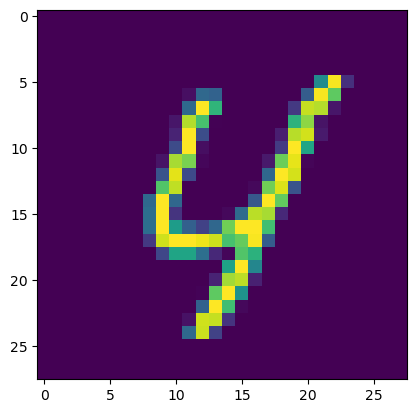

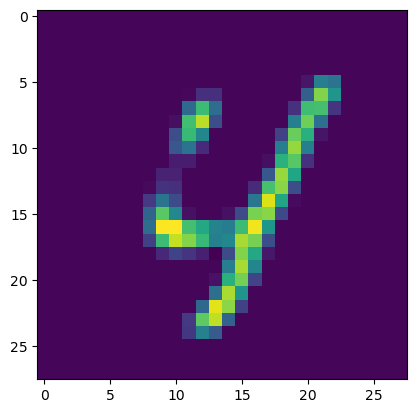

epoch: 11, step: 0, loss: 0.07145736366510391
epoch: 11, step: 200, loss: 0.06865877658128738
epoch: 11, step: 400, loss: 0.07116741687059402
epoch: 11, step: 600, loss: 0.0728040561079979
epoch: 11, step: 800, loss: 0.06863605231046677
epoch: 12, step: 0, loss: 0.07178044319152832
epoch: 12, step: 200, loss: 0.07178590446710587
epoch: 12, step: 400, loss: 0.07077956199645996
epoch: 12, step: 600, loss: 0.07020752876996994
epoch: 12, step: 800, loss: 0.06622274965047836
epoch: 13, step: 0, loss: 0.07249351590871811
epoch: 13, step: 200, loss: 0.06659155339002609
epoch: 13, step: 400, loss: 0.06822580099105835
epoch: 13, step: 600, loss: 0.06701971590518951
epoch: 13, step: 800, loss: 0.06973142176866531
epoch: 14, step: 0, loss: 0.06685005128383636
epoch: 14, step: 200, loss: 0.07010072469711304
epoch: 14, step: 400, loss: 0.06545163691043854
epoch: 14, step: 600, loss: 0.07412026077508926
epoch: 14, step: 800, loss: 0.07176516950130463
epoch: 15, step: 0, loss: 0.07311589270830154
epo

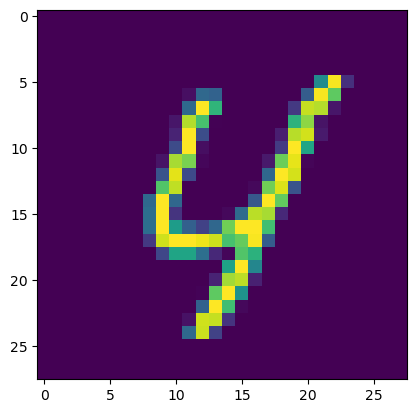

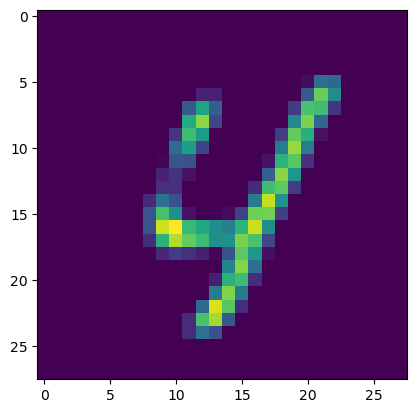

epoch: 16, step: 0, loss: 0.06571214646100998
epoch: 16, step: 200, loss: 0.07206416130065918
epoch: 16, step: 400, loss: 0.06897914409637451
epoch: 16, step: 600, loss: 0.0665949136018753
epoch: 16, step: 800, loss: 0.07120949774980545
epoch: 17, step: 0, loss: 0.06926554441452026
epoch: 17, step: 200, loss: 0.07141890376806259
epoch: 17, step: 400, loss: 0.06963131576776505
epoch: 17, step: 600, loss: 0.06622543931007385
epoch: 17, step: 800, loss: 0.07052259147167206
epoch: 18, step: 0, loss: 0.06689157336950302
epoch: 18, step: 200, loss: 0.06742488592863083
epoch: 18, step: 400, loss: 0.06593427062034607
epoch: 18, step: 600, loss: 0.07087358832359314
epoch: 18, step: 800, loss: 0.06569286435842514
epoch: 19, step: 0, loss: 0.06734364479780197
epoch: 19, step: 200, loss: 0.07378767430782318
epoch: 19, step: 400, loss: 0.06760399788618088
epoch: 19, step: 600, loss: 0.06660649925470352
epoch: 19, step: 800, loss: 0.0708065778017044


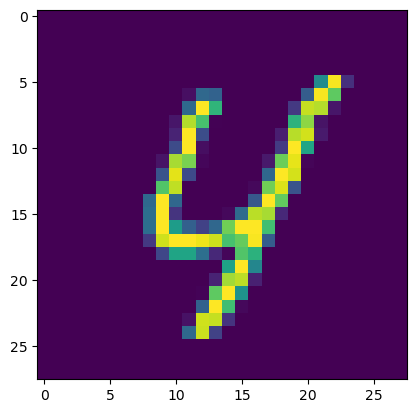

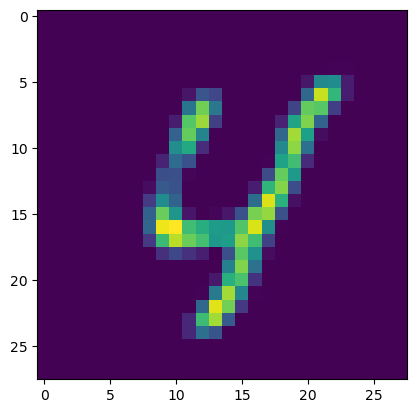

In [11]:
for epoch in range(n_epochs):
    model.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    if epoch % 5 == 0 or epoch == n_epochs - 1:
        model.eval()
        item = dataset_test[555][0].unsqueeze(0).to(device).float()
        plt.imshow(dataset_test[555][0].squeeze().detach().numpy())
        plt.show()
        plt.imshow(model(item).squeeze().squeeze().cpu().detach().numpy())
        plt.show()

2. Обучить VAE собственной архитектуры на MNIST

In [ ]:
Архитектура модели